# Recreating figure 3 (rectangle game heatmap) from Shafto 2014

- $6 \times 6$ grid
- Hypothesis space is all $2 \times 2$ to $5 \times 5$ rectangles (there should be 196 rectangles)
- Data points include all pairs of pixels, with pixels at each location being either a positive or negative example, like the line game. There should be 2520 unique labeled pairs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Generate hypothesis space

In [2]:
empty_grid = np.zeros((6, 6))

In [3]:
# Find all possible rectangle sizes and create rectangle for each size
rectangles = {}
for i in range(2, 6):
    for j in range(2, 6): 
        rectangles[(i, j)] = np.ones((i, j))

In [4]:
rectangles.keys()

dict_keys([(2, 2), (2, 3), (2, 4), (2, 5), (3, 2), (3, 3), (3, 4), (3, 5), (4, 2), (4, 3), (4, 4), (4, 5), (5, 2), (5, 3), (5, 4), (5, 5)])

In [5]:
# Generate hypothesis space
h = []

for k, v in rectangles.items():
    for i in range(empty_grid.shape[0]-k[0]+1): 
        for j in range(empty_grid.shape[1]-k[1]+1): 
            grid = np.zeros((6, 6))
            grid[i:v.shape[0]+i, j:v.shape[1]+j] = v
            h.append(grid)

In [6]:
len(h)

196

In [7]:
# Check a few items to see if h looks the way we want it to 
h[:3]

[array([[1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])]

## Generate data $(k=2)$

In [8]:
indices = []
for i in range(36): 
    for j in range(i+1, 36):
        indices.append((i, j))

In [9]:
len(indices)

630

In [10]:
empty_d = np.zeros(36)

In [11]:
def generate_data():
    d = []
    
    combs = [
        (1, 0), 
        (0, 1), 
        (0, 0), 
        (1, 1)
    ]

    for i in indices: 
        for j in combs: 
            d_i = np.zeros(36)
            d_i[:] = np.nan
            d_i[i[0]], d_i[i[1]] = j[0], j[1]
            d.append(d_i)
    
    return d

In [13]:
d = generate_data()
d[:3]

[array([ 1.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([ 0.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([ 0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])]

In [48]:
len(d)

2520

### Find iteration 0 probabilities

In [14]:
d_mask = np.ma.masked_invalid(d)

In [15]:
for i in range(len(h)): 
    h[i] = h[i].flatten()

In [16]:
d_possible = {}  # Set up dict of possible d for each h

df_0 = pd.DataFrame(np.zeros((len(d), len(h))))

# Loop over all combinations of h and d and fill dataframe with possible values
for row_h in range(len(h)): 
    for row_d in range(len(d)): 
        if np.array_equal(d[row_d][~d_mask.mask[row_d]], h[row_h][~d_mask.mask[row_d]]):
            # d_possible.setdefault(row_h+1, []).append(row_d+1)
            df_0.iloc[row_d, row_h] = 1  # uniform distribution of data given each hypothesis
            
# Turn values into probabilities; each column sums up to 1
df_0 = df_0.div(df_0.sum(axis=0), axis=1)

In [17]:
df_0

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000
2,0.000000,0.000000,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,...,0.000000,0.000000,0.001587,0.001587,0.001587,0.001587,0.000000,0.000000,0.001587,0.001587
3,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.000000
4,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.000000,0.001587
2516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.000000,0.001587,0.000000
2517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2518,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,...,0.001587,0.001587,0.001587,0.001587,0.000000,0.000000,0.001587,0.001587,0.000000,0.000000


### Make heatmaps

In [18]:
def make_heatmap_pos_ex(df, d, h_idx):
    heatmap = np.matmul(np.nan_to_num(np.stack(d).T), df[h_idx])
    heatmap = heatmap / np.sum(heatmap)
    heatmap = heatmap.reshape(6, 6)
    return heatmap

In [19]:
def set_negative_indices_to_one(d):
    d_copy = [i.copy() for i in d]

    for i in range(len(d)): 
        d_copy[i][d_copy[i] != 0] = np.nan
        d_copy[i][d_copy[i] == 0] = 1
        
    return d_copy

In [20]:
def make_heatmap_neg_ex(df, d, h_idx): 
    d = set_negative_indices_to_one(d)
    
    heatmap = np.matmul(np.nan_to_num(np.stack(d).T), df[h_idx])
    heatmap = heatmap / np.sum(heatmap)
    heatmap = heatmap.reshape(6, 6)
    return heatmap

In [21]:
make_heatmap_pos_ex(df_0, d, 35)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16666667, 0.16666667, 0.16666667,
        0.        ],
       [0.        , 0.        , 0.16666667, 0.16666667, 0.16666667,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [22]:
make_heatmap_neg_ex(df_0, d, 35)

array([[0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
        0.03333333],
       [0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
        0.03333333],
       [0.03333333, 0.03333333, 0.        , 0.        , 0.        ,
        0.03333333],
       [0.03333333, 0.03333333, 0.        , 0.        , 0.        ,
        0.03333333],
       [0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
        0.03333333],
       [0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
        0.03333333]])

### Iterate over model

In [23]:
def iterate_over_model(n, df_0):
    '''
    given number of iterations n and P(d|h) matrix for iteration 0, find P(d|h) matrix after iteration n 
    '''
    n_iter = n
    df = df_0

    for n in range(n_iter): 
        df = df.div(df.sum(axis=1), axis=0)  # P(h|d)
        df = df.div(df.sum(axis=0), axis=1)  # P(d|h)
    
    return df.fillna(0)

In [24]:
df_100 = iterate_over_model(100, df_0)

In [25]:
df_100

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.007502,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002909,0.000000,0.000000,0.000000,0.000000,0.000000,0.001003,0.000000,0.000000
2,0.000000,0.000000,0.00062,0.000552,0.000325,0.000552,0.000811,0.000887,0.000811,0.000552,...,0.000000,0.000000,0.000142,0.000142,0.000214,0.000142,0.000000,0.000000,0.000074,0.000074
3,0.006779,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002966,0.000000,0.000000,0.000000,0.000000,0.000000,0.001537,0.000000,0.000000,0.000000
4,0.022499,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004245,0.000000,0.000000,0.000000,0.002200
2516,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002909,0.000000,0.000000,0.000000,0.001003,0.000000
2517,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2518,0.000325,0.000552,0.00062,0.000552,0.000325,0.000552,0.000811,0.000887,0.000811,0.000552,...,0.000142,0.000214,0.000142,0.000142,0.000000,0.000000,0.000074,0.000074,0.000000,0.000000


### A few positive example heatmaps

<AxesSubplot:>

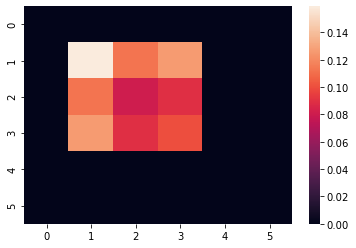

In [26]:
sns.heatmap(make_heatmap_pos_ex(df_100, d, 95))

<AxesSubplot:>

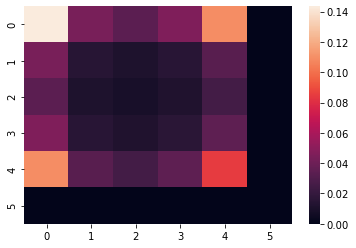

In [27]:
sns.heatmap(make_heatmap_pos_ex(df_100, d, 192))

## Make part a of the figure

Indices for the center 3x3 matrices are 95, 96, 99, 100

In [28]:
# Take mean of the four nonzero parts of the matrices

indices = [95, 96, 99, 100]
center_matrices = []

for i in indices: 
    heatmap = make_heatmap_pos_ex(df_100, d, i)
    center_matrices.append(heatmap[np.nonzero(heatmap)].reshape(3, 3))

center_matrices = np.stack(center_matrices)
center_matrices_heatmap = np.mean(center_matrices, axis=0)

In [44]:
center_matrices[0]

array([[0.15912491, 0.11299575, 0.12654956],
       [0.11299575, 0.08096778, 0.09010543],
       [0.12654956, 0.09010543, 0.10060584]])

In [29]:
center_matrices_heatmap

array([[0.12820747, 0.10155059, 0.12820747],
       [0.10155059, 0.08096778, 0.10155059],
       [0.12820747, 0.10155059, 0.12820747]])

In [30]:
# Find corners and non corners 
corner_idx = np.array([
    [1, 0, 1],
    [0, 0, 0], 
    [1, 0, 1]
])

corners = center_matrices_heatmap[corner_idx == 1]
non_corners = center_matrices_heatmap[corner_idx != 1]

In [46]:
# Find probabilities per unit area 
corner_breakdown = [np.sum(corners) / len(corners), np.sum(non_corners) / len(non_corners)]
corner_breakdown = corner_breakdown / np.sum(corner_breakdown)

corner_breakdown = {
    'corners': corner_breakdown[0],
    'non_corners': corner_breakdown[1]
}

In [47]:
corner_breakdown

{'corners': 0.5681910024110556, 'non_corners': 0.4318089975889445}

In [33]:
corner_noncorner_heatmap = np.empty((3, 3))
corner_noncorner_heatmap[corner_idx == 1] = corner_breakdown['corners']
corner_noncorner_heatmap[corner_idx == 0] = corner_breakdown['non_corners']

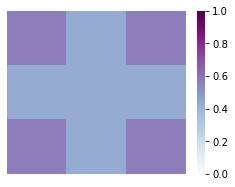

In [34]:
plt.figure(figsize=(4, 3))
_ = sns.heatmap(corner_noncorner_heatmap, vmin=0, vmax=1, cmap='BuPu', xticklabels=False, yticklabels=False)

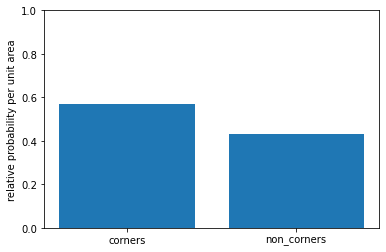

In [35]:
plt.bar(corner_breakdown.keys(), corner_breakdown.values())
plt.ylim((0, 1))
plt.ylabel('relative probability per unit area')
plt.show()

## Negative examples heatmap

In [36]:
# indices = [95, 96, 99, 100]
# center_matrices = []

# for i in indices: 
#     heatmap = make_heatmap_neg_ex(df_100, d, i)
#     center_matrices.append(heatmap[np.nonzero(heatmap)].reshape(3, 3))

# center_matrices = np.stack(center_matrices)
# center_matrices_heatmap = np.mean(center_matrices, axis=0)

In [37]:
make_heatmap_neg_ex(df_100, d, 95)

array([[0.03199832, 0.03575605, 0.03779863, 0.03688369, 0.0338623 ,
        0.03138218],
       [0.03575605, 0.        , 0.        , 0.        , 0.043019  ,
        0.0334852 ],
       [0.03779863, 0.        , 0.        , 0.        , 0.04877617,
        0.03476211],
       [0.03688369, 0.        , 0.        , 0.        , 0.04644573,
        0.03437487],
       [0.0338623 , 0.043019  , 0.04877617, 0.04644573, 0.03844092,
        0.03269208],
       [0.03138218, 0.0334852 , 0.03476211, 0.03437487, 0.03269208,
        0.03108472]])

<AxesSubplot:>

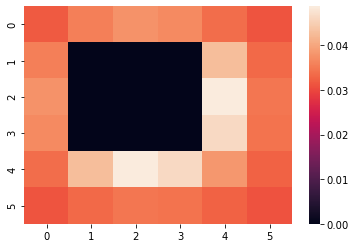

In [38]:
sns.heatmap(make_heatmap_neg_ex(df_100, d, 95))

<AxesSubplot:>

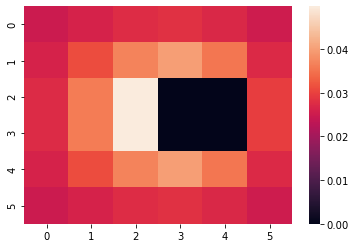

In [39]:
sns.heatmap(make_heatmap_neg_ex(df_100, d, 13))

## Part b of the figure